In [1]:
import random
import copy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading the merged train and test dataset

train_data = pd.read_pickle('merged_train.pkl')
test_data = pd.read_pickle('merged_test.pkl')

In [3]:
print("*"*45)
print("\n Train Data Shape : {} \n".format(train_data.shape))
print("\n Test Data Shape : {} \n".format(test_data.shape))
print("*"*45)

*********************************************

 Train Data Shape : (590540, 434) 


 Test Data Shape : (506691, 433) 

*********************************************


### Utility Functions

<br>

In [4]:
def cat_num_features(df):
    
    '''
        Utility Function to get the names of Categorical Features and 
        Numerical Features of the given Dataset.
    '''
    
    catf = []
    numf = []
    
    # Given Categorical Features 
    catf = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', \
            'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', \
            'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', \
            'DeviceType', 'DeviceInfo']
    catf+=['id_'+str(i) for i in range(12,39)]


    # Updating the Categorical Feature Names List based on the columns present in the dataframe
    catf = [feature for feature in catf if feature in df.columns.values]
    numf = [feature for feature in df.columns if feature not in catf and not feature == 'isFraud']
    
    return (catf, numf)  

In [5]:
def label_encode(X_train, X_cv, X_test, catf):
  
  '''
    Utility Function to Encode Categorical Features.
  '''

  for f in catf:
    
    X_train[f] = X_train[f].astype(str)
    X_test[f] = X_test[f].astype(str)
    
    le = LabelEncoder()
    le.fit(X_train[f])
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    X_train[f] = le.transform(X_train[f])
    
    # Manually Encoding the CV and Test Dataset so as to avoid error for any category which is not present in train set
    
    # All the categories which are not present in train datset are encoded as -1    
    X_cv[f] = [-1 if mapping.get(v, -1)==-1 else mapping[v] for v in X_cv[f].values ]
    X_test[f] = [-1 if mapping.get(v, -1)==-1 else mapping[v] for v in X_test[f].values ]

  return (X_train, X_cv, X_test)

In [6]:
def tpr_fpr_threshold_auc(Y, proba):
    
    '''
        Utility Function to return fpr, tpr, threshold and roc_auc.
    '''
    
    fpr, tpr, threshold = sklearn.metrics.roc_curve(Y, proba)
    roc_auc = metrics.auc(fpr, tpr)
    
    return (fpr, tpr, threshold, roc_auc)

In [7]:
#Reference: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

def train_cv_auc(train_fpr, train_tpr, train_roc_auc, cv_fpr, cv_tpr, cv_roc_auc):

    '''
        Utility Function to Draw ROC-AUC Curves for Train and Validation Datasets.
    '''
    
    plt.title('\nReceiver Operating Characteristic\n')
    plt.plot(train_fpr, train_tpr, label = 'Train AUC = %0.2f' % train_roc_auc)
    plt.plot(cv_fpr, cv_tpr, label = 'CV AUC = %0.2f' % cv_roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.show()

In [8]:
def best_threshold(threshold,tpr,fpr):
    
    '''
        Utility Function to return the best threshold value based on the TPR and FPR values.
    '''
    
    return threshold[np.argmax(tpr*(1-fpr))];


def class_label(best_thr, pred_score):
    
    '''
        Utility Function to return the class label based on the chosen threshold.
    '''
    return np.where(pred_score>best_thr,1,0);

In [9]:
#Reference: https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor

def draw_confusion_matrix(Y, predicted):
    
    '''
        Utility Function to draw Confusion Matrix.
    '''

    cv_cm = metrics.confusion_matrix(Y, predicted)
    sns.heatmap(cv_cm, annot=True,fmt="d",cmap='Oranges', xticklabels=['Legit', 'Fraudulent'], yticklabels=['Legit', 'Fraudulent'])
    plt.title('\nConfusion  Matrix\n')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.show()

In [10]:
def predict_and_save(prediction, name):
    
    '''
        Utility Function to save the test data predictions locally.
    '''
  
    df = pd.DataFrame({'TransactionID':test_ids.reshape(-1), 'isFraud':prediction.reshape(-1)})
    df = df.sort_values('TransactionID')
    df.to_csv(name, index=False)

## Data Preparation
<br>

### Splitting the Dataset
<br>

In [11]:
X = train_data.drop(['isFraud', 'TransactionID'], axis=1)
y = train_data['isFraud']

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.20, shuffle=False)
del X, y

X_test = test_data.drop(['TransactionID'], axis=1)
test_ids = test_data['TransactionID'].values

del train_data, test_data

In [12]:
print("*"*45)
print("\n Train Data Shape : {} \n".format(X_train.shape))
print("\n Cross Validation Data Shape : {} \n".format(X_cv.shape))
print("\n Test Data Shape : {} \n".format(X_test.shape))
print("*"*45)

*********************************************

 Train Data Shape : (472432, 432) 


 Cross Validation Data Shape : (118108, 432) 


 Test Data Shape : (506691, 432) 

*********************************************


In [14]:
# Storing Categorical and Numerical Feature Names 

catf, numf = cat_num_features(X_train)
categorical_feature_indices = [X_train.columns.get_loc(f) for f in catf]

#### Label Encoding Categorical Features
<br>

In [15]:
# Imputing the missing values of Categorical Columns with "missing"

X_train[catf] = X_train[catf].fillna('missing')
X_cv[catf] = X_cv[catf].fillna('missing')
X_test[catf] = X_test[catf].fillna('missing')


# Label Encoding Categorical Features

X_train, X_cv, X_test = label_encode(X_train, X_cv, X_test, catf)

# Decision Tree Modelling

In [21]:
from sklearn.tree import DecisionTreeClassifier
# 
# dt =  DecisionTreeClassifier(random_state=3, class_weight='balanced')
# dt.fit(X_train, y_train)


from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=3, class_weight='balanced'), param_grid, cv=5, n_jobs=9)
grid_search.fit(X_train, y_train)

dt = grid_search.best_estimator_


/Users/hojha/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/hojha/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/hojha/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/hojha/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/hojha/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas require

In [26]:
grid_search.best_params_


{'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

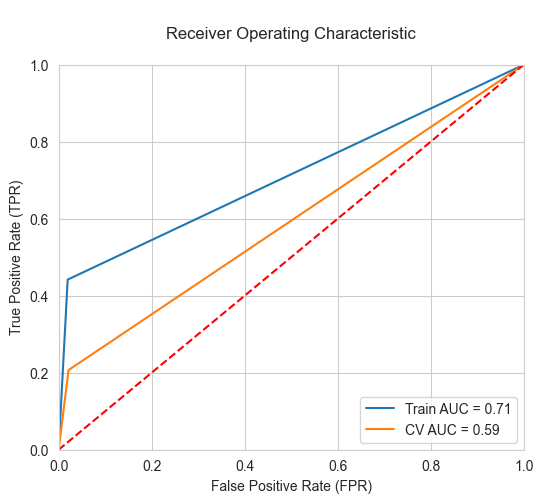

In [30]:
dt =  DecisionTreeClassifier(random_state=3, class_weight='balanced', criterion='entropy')
dt.fit(X_train, y_train)

train_proba = dt.predict_proba(X_train)[:, 1]
cv_proba = dt.predict_proba(X_cv)[:, 1]
test_proba = dt.predict_proba(X_test)[:, 1]
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, train_proba)
cv_fpr, cv_tpr, cv_threshold, cv_roc_auc = tpr_fpr_threshold_auc(y_cv, cv_proba)
plt.rcParams["figure.figsize"] = (6, 5)
train_cv_auc(train_fpr, train_tpr, train_roc_auc, cv_fpr, cv_tpr, cv_roc_auc)
    


In [25]:
grid_search.best_params_

{'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

## Modeling
<br>

In [17]:
clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=3000,
    tree_method='gpu_hist',
    random_state=3,
    subsample=0.8,
    max_depth=12,
    colsample_bytree=0.6,
    learning_rate=0.02
)

results = clf.fit(X_train, y_train, eval_set=[(X_cv, y_cv)], verbose=50, early_stopping_rounds=100)

[0]	validation_0-auc:0.81429
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.855966
[100]	validation_0-auc:0.862375
[150]	validation_0-auc:0.862453
[200]	validation_0-auc:0.863885
[250]	validation_0-auc:0.870111
[300]	validation_0-auc:0.872289
[350]	validation_0-auc:0.873308
[400]	validation_0-auc:0.873473
Stopping. Best iteration:
[344]	validation_0-auc:0.87418



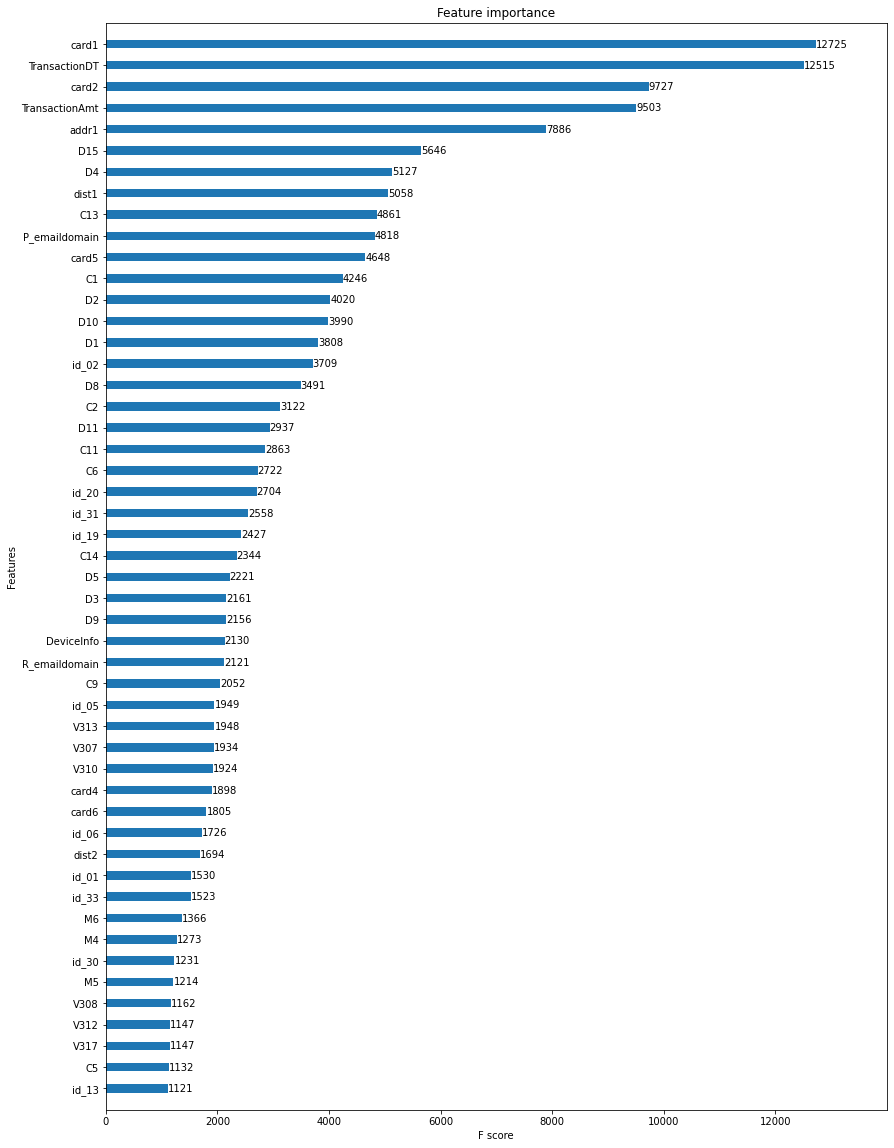

In [18]:
plt.rcParams["figure.figsize"] = (14, 20)
xgb.plot_importance(clf,max_num_features=50, grid=False, height=0.4)
plt.show()

In [19]:
train_proba = clf.predict_proba(X_train)[:,1]
cv_proba = clf.predict_proba(X_cv)[:,1]
test_proba = clf.predict_proba(X_test)[:,1]

In [20]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, train_proba)
cv_fpr, cv_tpr, cv_threshold, cv_roc_auc = tpr_fpr_threshold_auc(y_cv, cv_proba)

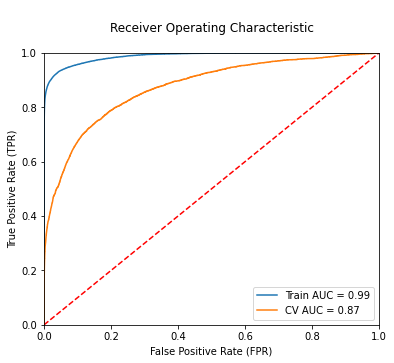

In [21]:
plt.rcParams["figure.figsize"] = (6, 5)
train_cv_auc(train_fpr, train_tpr, train_roc_auc, cv_fpr, cv_tpr, cv_roc_auc)

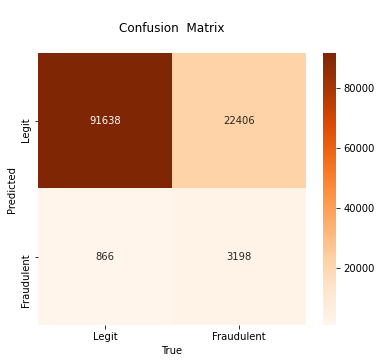

In [22]:
best_thr = best_threshold(cv_threshold, cv_tpr, cv_fpr)
cv_pred = class_label(best_thr, cv_proba)

draw_confusion_matrix(y_cv, cv_pred)

In [23]:
predict_and_save(test_proba, 'tuned_submission.csv')

> __Kaggle Submission__

<img src=https://i.ibb.co/7XxGYb7/Screenshot-from-2021-06-14-23-34-43.png>